In [1]:
# Change directory so that code in "src" directory is easily importable.
import os
os.chdir('../')
os.getcwd()

'/Users/binhu/projects/nba-in-game-prediction-models'

In [715]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from pyathena import connect
from pyathena.pandas_cursor import PandasCursor

from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

from mord import LogisticAT, LAD, OrdinalRidge

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import make_scorer, SCORERS, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)

# Define connection to DB
conn = connect(
    s3_staging_dir='s3://aws-athena-query-results-323906537337-us-east-1/',
    region_name='us-east-1',
    cursor_class=PandasCursor
    )
cursor = conn.cursor()

# 0 Data
## 0.1 Game data
### (1) game stats

In [3]:
simple_query = f'''
WITH game_opponents AS
(
    select 
      eventmetadata.gamecode game_code,
      event.teams[1].teamid team1_id, -- team1 is home team
      event.teams[2].teamid team2_id
    FROM datalakebasketball.api_events
    where leagueid = '1' 
        and season >= '2004'
)
            
select
  cast(t1.season as integer) season,
  t1.eventmetadata.gamecode game_code, 
  t1.eventmetadata.eventtypeid event_type_id,
  DATE_FORMAT(from_unixtime(t1.eventmetadata.gamedateutcepoch), '%Y-%m-%d') date,
  t1.teamid team_id,
  if(t1.teamid = t2.team1_id, 1, 0) at_home,
  if(t1.teamid = t2.team1_id, t2.team2_id, t2.team1_id) opp_team_id,
  t1.points,
  t1.fieldgoals.attempted fg_attempted, 
  t1.fieldgoals.made fg_made,
  t1.freethrows.attempted ft_attempted, 
  t1.freethrows.made ft_made,
  t1.rebounds.offensive offensive_rebounds, 
  t1.rebounds.defensive defensive_rebounds,
  t1.turnovers.total + t1.turnovers.team turnovers,
  t1.assists assists
from
  datalakebasketball.team_stats_game t1
  LEFT JOIN game_opponents t2
    ON t1.eventmetadata.gamecode=t2.game_code
where
  t1.season>='2004' and t1.season<='2018'
  and t1.leagueid='1'
  and t1.teamid not in (53, 54)   -- all_start teams
  and t1.eventmetadata.eventtypeid in (1,2)
  and t1.points is not null       -- filter out postponed games
order by t1.season, t1.teamid, t1.eventmetadata.gamedateutcepoch -- eventmetadata.gamecode
'''

if True:
    stats_df = cursor.execute(simple_query).as_pandas()
    print(stats_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38926 entries, 0 to 38925
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   season              38926 non-null  Int64 
 1   game_code           38926 non-null  Int64 
 2   event_type_id       38926 non-null  Int64 
 3   date                38926 non-null  object
 4   team_id             38926 non-null  Int64 
 5   at_home             38926 non-null  Int64 
 6   opp_team_id         38926 non-null  Int64 
 7   points              38926 non-null  Int64 
 8   fg_attempted        38926 non-null  Int64 
 9   fg_made             38926 non-null  Int64 
 10  ft_attempted        38926 non-null  Int64 
 11  ft_made             38926 non-null  Int64 
 12  offensive_rebounds  38926 non-null  Int64 
 13  defensive_rebounds  38926 non-null  Int64 
 14  turnovers           38926 non-null  Int64 
 15  assists             38926 non-null  Int64 
dtypes: Int64(15), object(1

In [ ]:
# why the stats for those games are missing?
# do I need to impute the missing values for those games?
# some games are simply postponed, such as 917610. Maybe the solution is to filter out those cases

In [4]:
# self join to create opponent parameters!
stats_df_opp = stats_df.drop(columns=['opp_team_id','event_type_id','at_home'])
id = stats_df_opp.columns.isin(['season','game_code','date','team_id'])
stats_df_opp.rename(columns={name:name+"_conceded" for name in stats_df_opp.columns[~id]}, inplace=True)
stats_df_opp.rename(columns={'team_id':'opp_team_id'}, inplace=True)

stats_df = pd.merge(stats_df, stats_df_opp, how='left', on=['season','game_code','date','opp_team_id'])

In [5]:
# groupby previous - seasonal average results
season_df = stats_df.drop(columns=['game_code','event_type_id','date','at_home','opp_team_id'])
season_df['season'] = season_df['season'] + 1
season_df = season_df.loc[season_df.season <= 2018]
gd = season_df.groupby(['season','team_id'])
season_df = gd.mean().reset_index()

# Use previous seasonal average to create initial values for current season: cross join
tmp = pd.DataFrame({'date':['00','01','02','03','04']})
tmp['key'] = 0
season_df['key'] = 0
initial_df = season_df.merge(tmp, how='left', on = 'key').drop(columns=['key'])
initial_df.head(11)

# combine initial values with current season game values
stats_df = stats_df.loc[stats_df.season > 2004]
stats_df = pd.concat([initial_df, stats_df], axis=0)
stats_df.sort_values(by=['season','team_id','date'], axis=0, inplace=True)

# calculate moving avg of last 5 games
id = stats_df.columns.isin(['season','team_id','opp_team_id','game_code','event_type_id','at_home','date'])
stats_df.rename(columns={name:name+'_l5' for name in stats_df.columns[~id]}, inplace=True)

gd = stats_df.groupby(by=['season','team_id'])
stats_df.loc[:,~id] = gd.apply(lambda df: df.loc[:,~id].rolling(5).mean().shift(1))

stats_df = stats_df.loc[stats_df.date>'04',:]

# stats_df add game index for each team
gd = stats_df.groupby(['season','team_id'])
stats_df['game_num'] = gd.cumcount() + 1
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36298 entries, 2628 to 38925
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          36298 non-null  Int64  
 1   team_id                         36298 non-null  Int64  
 2   points_l5                       36298 non-null  float64
 3   fg_attempted_l5                 36298 non-null  float64
 4   fg_made_l5                      36298 non-null  float64
 5   ft_attempted_l5                 36298 non-null  float64
 6   ft_made_l5                      36298 non-null  float64
 7   offensive_rebounds_l5           36298 non-null  float64
 8   defensive_rebounds_l5           36298 non-null  float64
 9   turnovers_l5                    36298 non-null  float64
 10  assists_l5                      36298 non-null  float64
 11  points_conceded_l5              36298 non-null  float64
 12  fg_attempted_conceded_l5     

### (2) Elo rating

In [6]:
# Note: 
#  > in elo_data, team_1 is home team
#  > data issue in 2007, MIA vs ATL on 2007-12-19 was mistakenly placed on 2008-03-07, thus mess up whole season elo
os.getcwd()
elo_data = pd.read_csv('runtime/datasets/nba_elo.csv')
elo_data.season = elo_data.season - 1
elo_data = elo_data[(elo_data.season>=2005) & (elo_data.season<=2018) & (elo_data.season!=2007)]

# drop not needed columns
#id = [bool(re.match("(carm)|(raptor)|(playoff)|(neutral).*", name)) for name in elo_data.columns]
#elo_data=elo_data.loc[:, ~np.array(id)]
elo_data = elo_data[['date','season','team1','team2','elo1_pre','elo2_pre']]
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16833 entries, 50257 to 68405
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      16833 non-null  object 
 1   season    16833 non-null  int64  
 2   team1     16833 non-null  object 
 3   team2     16833 non-null  object 
 4   elo1_pre  16833 non-null  float64
 5   elo2_pre  16833 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 920.6+ KB


In [664]:
# add team_id
team_dict = {'ATL':1, 'BOS':2, 'BRK':17, 'CHI':4, 'CHO':5312, 'CLE':5, 'DAL':6, 'DEN':7, 'DET':8,
       'GSW':9, 'HOU':10, 'IND':11, 'LAC':12, 'LAL':13, 'MEM':29, 'MIA':14, 'MIL':15, 'MIN':16,
       'NJN':17, 'NOK':3, 'NOP':3, 'NYK':18, 'OKC':25, 'ORL':19, 'PHI':20, 'PHO':21, 'POR':22,
       'SAC':23, 'SAS':24, 'SEA':25, 'TOR':28, 'UTA':26, 'WAS':27}
team_dict = pd.DataFrame(pd.Series(team_dict) ).reset_index()
team_dict.columns = ['team','team_id']

elo_data = pd.merge(elo_data, team_dict, left_on='team1', right_on='team', how='left')
elo_data.drop('team', axis=1, inplace=True)
elo_data.rename(columns={'team_id':'team1_id'}, inplace=True)

elo_data = pd.merge(elo_data, team_dict, left_on='team2', right_on='team', how='left')
elo_data.drop('team', axis=1, inplace=True)
elo_data.rename(columns={'team_id':'team2_id'}, inplace=True)

In [669]:
team_dict.sort_values(by='team_id', inplace=True)
team_dict.reset_index(drop=True)

,team,team_id
0,ATL,1
1,BOS,2
2,NOP,3
3,CHI,4
4,CLE,5
5,DAL,6
6,DEN,7
7,DET,8
8,GSW,9
9,HOU,10


In [8]:
# add game_num for each team
# concat game team pair into one team dataframe
df_1 = elo_data.loc[:,['date','season','team1_id']]
df_2 = elo_data.loc[:,['date','season','team2_id']]

df_1.rename(columns={'team1_id':'team_id'}, inplace=True)
df_2.rename(columns={'team2_id':'team_id'}, inplace=True)

df = pd.concat([df_1,df_2], axis=0).sort_values(by=['season','team_id','date'])

gd = df.groupby(['season','team_id'])
df['game_num'] = gd.cumcount() + 1

# merge game_num back into elo_data
elo_data = pd.merge(elo_data, df, how='left', left_on=['date','season','team1_id'], right_on=['date','season','team_id'])
elo_data.rename(columns={'game_num':'team1_game_num'}, inplace=True)
elo_data.drop(columns=['team_id'], inplace=True)

elo_data=pd.merge(elo_data, df, how='left', left_on=['date','season','team2_id'], right_on=['date','season','team_id'])
elo_data.rename(columns={'game_num':'team2_game_num'}, inplace=True)
elo_data.drop(columns=['team_id'], inplace=True)

In [9]:
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16833 entries, 0 to 16832
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            16833 non-null  object 
 1   season          16833 non-null  int64  
 2   team1           16833 non-null  object 
 3   team2           16833 non-null  object 
 4   elo1_pre        16833 non-null  float64
 5   elo2_pre        16833 non-null  float64
 6   team1_id        16833 non-null  int64  
 7   team2_id        16833 non-null  int64  
 8   team1_game_num  16833 non-null  int64  
 9   team2_game_num  16833 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 1.4+ MB


In [10]:
# merge stats_df and elo_data
game_df = pd.merge(elo_data, stats_df.drop(columns=['date','opp_team_id']), how='left', 
                                           left_on=['season','team1_id','team1_game_num'], 
                                            right_on=['season','team_id','game_num'])
game_df.drop(columns=['game_num','team_id'], inplace=True)

game_df.info()

col_names = ['points_l5', 'fg_attempted_l5', 'fg_made_l5',
                   'ft_attempted_l5', 'ft_made_l5', 'offensive_rebounds_l5',
                   'defensive_rebounds_l5', 'turnovers_l5', 'assists_l5',
                    'points_conceded_l5',
                   'fg_attempted_conceded_l5', 'fg_made_conceded_l5',
                   'ft_attempted_conceded_l5', 'ft_made_conceded_l5',
                   'offensive_rebounds_conceded_l5', 'defensive_rebounds_conceded_l5',
                   'turnovers_conceded_l5', 'assists_conceded_l5'
            ]
game_df.rename(columns={name:('t1_'+name) for name in col_names}, inplace=True)

game_df = pd.merge(game_df, stats_df.drop(columns=['date','game_code','event_type_id','at_home','opp_team_id']), how='left', 
                                        left_on=['season','team2_id','team2_game_num'], 
                                         right_on=['season','team_id','game_num'])

game_df.drop(columns=['game_num','team_id'], inplace=True)

game_df.rename(columns={name:('t2_'+name) for name in col_names}, inplace=True)
game_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16833 entries, 0 to 16832
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   date                            16833 non-null  object 
 1   season                          16833 non-null  int64  
 2   team1                           16833 non-null  object 
 3   team2                           16833 non-null  object 
 4   elo1_pre                        16833 non-null  float64
 5   elo2_pre                        16833 non-null  float64
 6   team1_id                        16833 non-null  int64  
 7   team2_id                        16833 non-null  int64  
 8   team1_game_num                  16833 non-null  int64  
 9   team2_game_num                  16833 non-null  int64  
 10  points_l5                       16833 non-null  float64
 11  fg_attempted_l5                 16833 non-null  float64
 12  fg_made_l5                      

## 0.2 in-game team data

In [ ]:
simple_query = f'''
with t1 as(
    select 
        CAST(season AS INTEGER) season,
        eventmetadata.gamecode game_code,
        eventmetadata.eventtypeid event_type_id,

        if(teammetadata[1].ishometeam, teammetadata[1].score, teammetadata[2].score ) home_final_score,
        if(teammetadata[1].ishometeam, teammetadata[2].score, teammetadata[1].score ) away_final_score,

        CAST(pbp.playid AS INTEGER) play_id, 
        pbp.period,
        GREATEST(4 - pbp.period, 0)*720 + pbp.time.minutes*60 + CAST(pbp.time.seconds AS double) time_left,

        pbp.teamid team_id,

        if((teammetadata[1].ishometeam and teammetadata[1].teamid=pbp.teamid) or
          (teammetadata[2].ishometeam and teammetadata[2].teamid=pbp.teamid), 1, 0) is_home_team,

        pbp.playevent.playeventid play_event_id, 
        pbp.playevent.name play_name, -- pbp.playtext play_text,

        if(pbp.playevent.playeventid in (1,2), 1, 0) ft_attempts,
        if(pbp.playevent.playeventid in (3,4), 1, 0) fg_attempts,
        if(pbp.playevent.playeventid in (5), 1, 0) offensive_rebounds,
        if(pbp.playevent.playeventid in (6), 1, 0) defensive_rebounds,
        if(pbp.playevent.playeventid in (7), 1, 0) turnover,

        pbp.homescore home_score, pbp.visitorscore away_score, 
        pbp.homefouls home_fouls, pbp.visitorfouls away_fouls
    from datalakebasketball.pbp
    where pbp.leagueid='1' 
        and pbp.teamid is not null
        and season='2004'
    order by season, game_code, play_id
)
  
select
    season, game_code, event_type_id, home_final_score, away_final_score,
    play_id, period, time_left, team_id, is_home_team, play_event_id,

    home_score, away_score,
    home_fouls, away_fouls,

    if(is_home_team=1, t1.ft_attempts, 0) home_ft_attempts,
    if(is_home_team=0, t1.ft_attempts, 0) away_ft_attempts,

    if(is_home_team=1, t1.fg_attempts, 0) home_fg_attempts,
    if(is_home_team=0, t1.fg_attempts, 0) away_fg_attempts,

    if(is_home_team=1, t1.offensive_rebounds, 0) home_offensive_rebounds,
    if(is_home_team=0, t1.offensive_rebounds, 0) away_offensive_rebounds,

    if(is_home_team=1, t1.defensive_rebounds, 0) home_defensive_rebounds,
    if(is_home_team=0, t1.defensive_rebounds, 0) away_defensive_rebounds,

    if(is_home_team=1, t1.turnover, 0) home_turnover,
    if(is_home_team=0, t1.turnover, 0) away_turnover
from t1
'''

if True:
    pbp_df = cursor.execute(simple_query).as_pandas()
    print(pbp_df.info())
else:
    print("Failed to query!")

## 0.3 player data

In [756]:
simple_query = f'''
WITH players AS (
    SELECT
        playerid player_id,
        draft.year
    FROM datalakebasketball.players
    where draft.year is not null
),
teams AS (
    SELECT 
        api.eventmetadata.gamecode game_code,
        teams.teamid team_id,
        if(teams.teamlocationtype.teamlocationtypeid = 1,
            1,
            0) AS is_home_team
    FROM datalakebasketball.api_events api, UNNEST(api.event.teams) t(teams)
    WHERE leagueid = '1'
                AND season >= '2004'
                AND season <= '2018'
                and eventmetadata.eventtypeid=1
)

SELECT
    CAST(season AS INTEGER) season,
    eventmetadata.gamecode game_code,
    eventmetadata.gamedateutcepoch game_time,
    player.playerid player_id, 
    --player.firstname first_name,
    --player.lastname last_name,
    team.teamid team_id, 
    t3.is_home_team at_home, 
    positionid position_id, 
    t2.year draft_year,
    --isgameplayed game_played, 
    isgamestarted game_started,
    minutesplayed minutes,
    points,
    fieldgoals.attempted fg_attempt, 
    fieldgoals.made fg_made,
    freethrows.attempted ft_attempt, 
    freethrows.made ft_made,
    threepointfieldgoals.attempted point_3_attempt, 
    threepointfieldgoals.made point_3_made,
    rebounds.offensive offensive_rebounds, 
    rebounds.defensive defensive_rebounds, 
    assists, 
    blockedshots blocks, 
    turnovers
FROM 
    datalakebasketball.player_stats_game t1
    LEFT JOIN players t2 
        ON t1.player.playerid=t2.player_id
    LEFT JOIN teams t3
        ON t1.eventmetadata.gamecode=t3.game_code AND t1.team.teamid=t3.team_id
WHERE 
    leagueid='1' 
    AND eventmetadata.eventtypeid=1 
    AND season>='2004'
    AND season<='2018'
    AND isgameplayed -- does this mean eligibility to play?
ORDER BY 
    season, player_id, game_time
'''

if True:
    player_df = cursor.execute(simple_query).as_pandas()
    print(player_df.info())
else:
    print("Failed to query!")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376975 entries, 0 to 376974
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   season              376975 non-null  Int64
 1   game_code           376975 non-null  Int64
 2   game_time           376975 non-null  Int64
 3   player_id           376975 non-null  Int64
 4   team_id             376975 non-null  Int64
 5   at_home             376975 non-null  Int64
 6   position_id         182090 non-null  Int64
 7   draft_year          327581 non-null  Int64
 8   game_started        376975 non-null  bool 
 9   minutes             376975 non-null  Int64
 10  points              376975 non-null  Int64
 11  fg_attempt          376975 non-null  Int64
 12  fg_made             376975 non-null  Int64
 13  ft_attempt          376975 non-null  Int64
 14  ft_made             376975 non-null  Int64
 15  point_3_attempt     376975 non-null  Int64
 16  point_3_made        

In [ ]:
# (1) Create recent stats (mean of last 10 games) for all players
# (2) The first 10 games, an average of current game and past season results
# (3) If a player doesn't have previous season record (rookie), the 1st 10 games of such players are skipped
# (4) merge team stats/elo rating into player data, only keep elo and rebounds for now

In [757]:
# groupby previous - seasonal player average results
player_season_df = player_df.drop(columns=['game_code','game_time','position_id','team_id','at_home','draft_year',
                                                  'game_started'])
gd = player_season_df.groupby(['season','player_id'])
player_season_df = gd.mean().reset_index()

player_season_df['season'] = player_season_df['season'] + 1
player_season_df = player_season_df.loc[player_season_df.season <= 2018]

# Use previous seasonal average to create initial values for current season
tmp = pd.DataFrame({'game_time':[*range(10)], 'game_started':[False]*10})

# This is called cross-join!
tmp['key'] = 0
player_season_df['key'] = 0
initial_df = player_season_df.merge(tmp, how='left', on = 'key').drop(columns=['key'])

# combine initial values with current season game values
player_df = player_df.loc[player_df.season > 2004]
player_df = pd.concat([initial_df, player_df], axis=0)
player_df.sort_values(by=['season','player_id','game_time'], axis=0, inplace=True)
player_df.reset_index(inplace=True, drop=True)
player_df.head(11)

# calculate moving avg of last 10 games (only when the player actually played)
# special case I: a player in last season, but not this season, will be filtered out
#.             II: a rookie player -> no previous season data, so we will give up the 1st 10 games in modeling
#                  , but in production system, we may want human inputs as the initial guess

id = player_df.columns.isin(['minutes',
                               'points', 'fg_attempt', 'fg_made', 'ft_attempt', 'ft_made',
                               'point_3_attempt', 'point_3_made', 'offensive_rebounds',
                               'defensive_rebounds', 'assists', 'blocks', 'turnovers'])

gd = player_df.groupby(by=['season','player_id'])
tmp = gd.apply(lambda df: df.loc[:,id].rolling(10).mean().shift(1))

tmp.rename(columns={name:name+'_l10' for name in tmp.columns}, inplace=True)

player_df = pd.concat([player_df, tmp], axis=1) 

player_df = player_df.loc[~player_df.minutes_l10.isnull()]
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340295 entries, 70 to 417949
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   season                  340295 non-null  Int64  
 1   player_id               340295 non-null  Int64  
 2   minutes                 340295 non-null  Float64
 3   points                  340295 non-null  Float64
 4   fg_attempt              340295 non-null  Float64
 5   fg_made                 340295 non-null  Float64
 6   ft_attempt              340295 non-null  Float64
 7   ft_made                 340295 non-null  Float64
 8   point_3_attempt         340295 non-null  Float64
 9   point_3_made            340295 non-null  Float64
 10  offensive_rebounds      340295 non-null  Float64
 11  defensive_rebounds      340295 non-null  Float64
 12  assists                 340295 non-null  Float64
 13  blocks                  340295 non-null  Float64
 14  turnovers          

In [758]:
# calculate rates per min
rates_name = ['points_l10', 'fg_attempt_l10', 'fg_made_l10', 'ft_attempt_l10',
               'ft_made_l10', 'point_3_attempt_l10', 'point_3_made_l10',
               'offensive_rebounds_l10', 'defensive_rebounds_l10', 'assists_l10',
               'blocks_l10', 'turnovers_l10']
player_df.loc[:, rates_name] = player_df.loc[:, rates_name].div(player_df.minutes_l10, axis='index')

In [759]:
# merge team stats/elo into game_df

tmp1 = game_df.loc[:,['season','game_code','team1_id','team2_id','elo1_pre',
                        't1_offensive_rebounds_l5', 't1_defensive_rebounds_l5',
                        't1_offensive_rebounds_conceded_l5', 't1_defensive_rebounds_conceded_l5']]

tmp2 = game_df.loc[:,['season','game_code','team2_id','team1_id','elo2_pre',
                        't2_offensive_rebounds_l5', 't2_defensive_rebounds_l5',
                        't2_offensive_rebounds_conceded_l5', 't2_defensive_rebounds_conceded_l5']]

tmp1.columns = tmp2.columns = ['season','game_code','team_id','opp_id','team_elo',
                                  'team_o_rebounds_l5', 'team_d_rebounds_l5',
                                  'team_o_rebounds_conceded_l5', 'team_d_rebounds_conceded_l5']

tmp3 = pd.concat([tmp1, tmp2], axis=0)
print(tmp3.shape)
tmp3.head()

(33666, 9)


,season,game_code,team_id,opp_id,team_elo,team_o_rebounds_l5,team_d_rebounds_l5,team_o_rebounds_conceded_l5,team_d_rebounds_conceded_l5
0,2005,667196,3,23,1366.3867,12.426829,27.817073,11.548780,30.304878
1,2005,659641,24,7,1648.5449,12.104762,30.219048,11.114286,28.876190
2,2005,659639,20,15,1494.3020,11.000000,30.597701,11.574713,32.448276
3,2005,659645,21,6,1644.8823,11.835052,32.144330,14.927835,30.814433
4,2005,659663,10,23,1623.8481,10.662921,31.348315,11.078652,29.651685


In [649]:
player_df.season.unique()

<IntegerArray>
[2005, 2006, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Length: 13, dtype: Int64

In [760]:
# adding features related to player's team
player_df = player_df[player_df.season!=2007]
player_df = pd.merge(player_df, tmp3, how='left', 
                       left_on=['season','game_code','team_id'], 
                       right_on=['season','game_code','team_id'])

tmp4 = tmp3.drop(columns=['opp_id'])
tmp4.columns = ['season', 'game_code', 'opp_id', 'opp_elo',
                   'opp_o_rebounds_l5', 'opp_d_rebounds_l5',
                   'opp_o_rebounds_conceded_l5', 'opp_d_rebounds_conceded_l5']

# adding features related to player's opponent team
player_df = pd.merge(player_df, tmp4, how='left', 
                       left_on=['season','game_code','opp_id'], 
                       right_on=['season','game_code','opp_id'])
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316132 entries, 0 to 316131
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   season                       316132 non-null  Int64  
 1   player_id                    316132 non-null  Int64  
 2   minutes                      316132 non-null  Float64
 3   points                       316132 non-null  Float64
 4   fg_attempt                   316132 non-null  Float64
 5   fg_made                      316132 non-null  Float64
 6   ft_attempt                   316132 non-null  Float64
 7   ft_made                      316132 non-null  Float64
 8   point_3_attempt              316132 non-null  Float64
 9   point_3_made                 316132 non-null  Float64
 10  offensive_rebounds           316132 non-null  Float64
 11  defensive_rebounds           316132 non-null  Float64
 12  assists                      316132 non-null  Float64
 13 

# 1 Feature / label creation

## 1.1 team model

In [732]:
num_fields = ['elo1_pre', 'elo2_pre', 
                    
                    't1_points_l5',
                    't1_fg_attempted_l5', 't1_fg_made_l5', 
                    't1_ft_attempted_l5', 't1_ft_made_l5', 
                    't1_offensive_rebounds_l5', 't1_defensive_rebounds_l5',
                    't1_turnovers_l5', 
                    
                    't1_points_conceded_l5',
                    't1_fg_attempted_conceded_l5', 't1_fg_made_conceded_l5',
                    't1_ft_attempted_conceded_l5', 't1_ft_made_conceded_l5',
                    't1_offensive_rebounds_conceded_l5', 't1_defensive_rebounds_conceded_l5', 
                    't1_turnovers_conceded_l5',
                    
                    't2_points_l5', 
                    't2_fg_attempted_l5', 't2_fg_made_l5',
                    't2_ft_attempted_l5', 't2_ft_made_l5', 
                    't2_offensive_rebounds_l5', 't2_defensive_rebounds_l5', 
                    't2_turnovers_l5', 
                    
                    't2_points_conceded_l5',
                    't2_fg_attempted_conceded_l5', 't2_fg_made_conceded_l5',
                    't2_ft_attempted_conceded_l5', 't2_ft_made_conceded_l5',
                    't2_offensive_rebounds_conceded_l5', 't2_defensive_rebounds_conceded_l5', 
                    't2_turnovers_conceded_l5'
             ]
cat_fields = []

In [ ]:
id_train = (game_df.season < 2018)  #& (pbp_df.period <= 4) #| (win_df.week < 22)) 
id_test  = (game_df.season == 2018) #& (pbp_df.period <= 4) # & (~win_df['winProbability.before'].isnull())

# None-StandardScaler version
transform_pipeline = ColumnTransformer(transformers=[
                                            ('num', StandardScaler(), num_fields),
                                            #('cat', OneHotEncoder(categories='auto'), cat_fields)
                                        ])

features_train = transform_pipeline.fit_transform(game_df[id_train])
features_test  = transform_pipeline.transform(game_df[id_test])

feature_names = num_fields.copy()
# cat_one_hot_fields = list(transform_pipeline_drive.named_transformers_.cat.get_feature_names(input_features=cat_fields_drive))
# feature_names_drive.extend(cat_one_hot_fields)

print(features_train.shape, features_test.shape)

In [ ]:
# for non-parametric modeling -> label needs to be put into numerical categories
label = game_df.score1 - game_df.score2
label = label.astype('int32')
label.loc[label > 20] = 20
label.loc[label < -20] = -20
label[label>0] = label[label>0] - 1
label_train = label[id_train]
lable_test  = label[id_test]

In [ ]:
label.describe()
np.sort(label.unique())
plt.hist(label, bins=39)

## 1.2 player model

In [761]:
# position id not added since it lacks a lot and only 3 position type?
# for team stats, medium imputation makes sense; for player stats, medium vs 0 which is better?

num_fields_player = [
                     # player stats   
                    'minutes_l10', 
                    'points_l10',
                    'fg_attempt_l10', 'fg_made_l10', 
                    'ft_attempt_l10', 'ft_made_l10',
                    'point_3_attempt_l10', 'point_3_made_l10', 
                    'offensive_rebounds_l10','defensive_rebounds_l10', 
                    'assists_l10', 
                    'blocks_l10', 
                    'turnovers_l10',

                    # team stats
                    'team_o_rebounds_l5', 'team_d_rebounds_l5',
                    'team_o_rebounds_conceded_l5', 'team_d_rebounds_conceded_l5', 
                    'opp_o_rebounds_l5', 'opp_d_rebounds_l5', 
                    'opp_o_rebounds_conceded_l5', 'opp_d_rebounds_conceded_l5',
    
                    # team elo
                    'team_elo', 
                    'opp_elo',
                     ]
cat_fields_player = ['at_home','game_started']

In [762]:
player_df = player_df.astype({'minutes':'float64', 'points':'float64', 'fg_attempt':'float64', 'fg_made':'float64',
       'ft_attempt':'float64', 'ft_made':'float64', 'point_3_attempt':'float64', 'point_3_made':'float64',
       'offensive_rebounds':'float64', 'defensive_rebounds':'float64', 'assists':'float64', 'blocks':'float64',
       'turnovers':'float64'})

player_df = player_df.astype({'season':'int64', 'player_id':'int64', 'game_time':'int64', 'game_code':'int64', 
                              'team_id':'int64', 'at_home':'int64'})

In [735]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316132 entries, 0 to 316131
Data columns (total 46 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   season                       316132 non-null  int64  
 1   player_id                    316132 non-null  int64  
 2   minutes                      316132 non-null  float64
 3   points                       316132 non-null  float64
 4   fg_attempt                   316132 non-null  float64
 5   fg_made                      316132 non-null  float64
 6   ft_attempt                   316132 non-null  float64
 7   ft_made                      316132 non-null  float64
 8   point_3_attempt              316132 non-null  float64
 9   point_3_made                 316132 non-null  float64
 10  offensive_rebounds           316132 non-null  float64
 11  defensive_rebounds           316132 non-null  float64
 12  assists                      316132 non-null  float64
 13 

In [763]:
# May need to add imputer for data transformation!
id_train = (player_df.season < 2018)  #& (pbp_df.period <= 4) #| (win_df.week < 22)) 
id_test  = (player_df.season == 2018) #& (pbp_df.period <= 4) # & (~win_df['winProbability.before'].isnull())

num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('std_scaler', StandardScaler())
                         ])

# None-StandardScaler version
transform_pipeline_player = ColumnTransformer(transformers=[
                                                ('num', num_pipeline, num_fields_player),
                                                ('cat', OneHotEncoder(categories='auto'), cat_fields_player)
                                            ])

features_train_player = transform_pipeline_player.fit_transform(player_df[id_train])
features_test_player  = transform_pipeline_player.transform(player_df[id_test])

feature_names_player = num_fields_player.copy()
cat_one_hot_fields = list(transform_pipeline_player.named_transformers_.cat.get_feature_names(input_features=cat_fields_player))
feature_names_player.extend(cat_one_hot_fields)

print(features_train_player.shape, features_test_player.shape)

from joblib import dump, load
dump(transform_pipeline_player, 'transform_pipeline.joblib')

tmp = load('transform_pipeline.joblib') 
x  = tmp.transform(player_df[id_test])

(290996, 27) (25136, 27)


In [764]:
# output testing data

player_df.loc[player_df.season == 2018].to_csv('./notebooks/player_2018.csv', index=False)

In [765]:
pd.read_csv('./notebooks/player_2018.csv')

,season,player_id,minutes,points,fg_attempt,fg_made,ft_attempt,ft_made,point_3_attempt,point_3_made,offensive_rebounds,defensive_rebounds,assists,blocks,turnovers,game_time,game_started,game_code,team_id,at_home,position_id,draft_year,minutes_l10,points_l10,fg_attempt_l10,fg_made_l10,ft_attempt_l10,ft_made_l10,point_3_attempt_l10,point_3_made_l10,offensive_rebounds_l10,defensive_rebounds_l10,assists_l10,blocks_l10,turnovers_l10,opp_id,team_elo,team_o_rebounds_l5,team_d_rebounds_l5,team_o_rebounds_conceded_l5,team_d_rebounds_conceded_l5,opp_elo,opp_o_rebounds_l5,opp_d_rebounds_l5,opp_o_rebounds_conceded_l5,opp_d_rebounds_conceded_l5
0,2018,3230,24.0,12.0,9.0,4.0,2.0,2.0,6.0,2.0,0.0,2.0,0.0,0.0,2.0,1539819000,True,2074542,1,0,7.0,1998.0,17.706897,0.304771,0.275560,0.111003,0.036027,0.027264,0.160662,0.055501,0.017527,0.126582,0.067186,0.025316,0.035054,18,1388.023047,9.060976,32.841463,10.256098,33.963415,1409.590805,10.475610,33.560976,10.219512,32.951220
1,2018,3230,20.0,10.0,7.0,2.0,4.0,4.0,5.0,2.0,0.0,2.0,1.0,1.0,0.0,1539993600,True,2074076,1,0,7.0,1998.0,18.336207,0.330324,0.288575,0.118289,0.042219,0.034603,0.172355,0.059144,0.015233,0.120921,0.058392,0.022003,0.041373,29,1378.461020,8.648780,33.873171,10.204878,34.370732,1362.003360,9.000000,29.019512,10.229268,35.170732
2,2018,3230,12.0,3.0,3.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,0.0,1.0,1540159200,True,2073645,1,0,7.0,1998.0,18.565517,0.351040,0.296434,0.117013,0.059807,0.053120,0.181835,0.063893,0.013373,0.118128,0.056649,0.024703,0.037519,5,1369.249374,9.036585,33.104878,9.553659,34.378049,1544.961726,10.644231,32.938462,9.123077,33.201923
3,2018,3230,26.0,6.0,5.0,2.0,0.0,0.0,4.0,2.0,0.0,5.0,0.0,0.0,0.0,1540422000,True,2074481,1,1,7.0,1998.0,17.994828,0.348855,0.295391,0.115359,0.058158,0.052122,0.182907,0.066015,0.012072,0.109418,0.062949,0.022995,0.040816,6,1406.551396,9.024390,33.536585,10.502439,34.385366,1391.680704,10.848780,29.853659,7.336585,33.165854
4,2018,3230,23.0,12.0,9.0,4.0,0.0,0.0,7.0,4.0,0.0,2.0,1.0,1.0,1.0,1540683000,True,2074490,1,1,7.0,1998.0,18.824138,0.336692,0.283019,0.110460,0.052207,0.047261,0.180986,0.068511,0.009892,0.119253,0.053856,0.019601,0.035721,4,1411.797685,9.212195,35.768293,10.251220,36.192683,1350.998853,6.800000,31.800000,12.200000,34.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25131,2018,1121334,24.0,11.0,14.0,4.0,1.0,0.0,11.0,3.0,0.0,5.0,3.0,0.0,1.0,1554584400,True,2073854,17,0,7.0,2018.0,19.800000,0.262626,0.267677,0.101010,0.070707,0.020202,0.136364,0.040404,0.015152,0.171717,0.030303,0.040404,0.070707,15,1470.348763,11.200000,39.200000,11.000000,35.200000,1703.617953,9.800000,43.800000,10.200000,39.400000
25132,2018,1121334,16.0,4.0,10.0,2.0,0.0,0.0,2.0,0.0,4.0,3.0,1.0,0.0,1.0,1554670800,True,2074053,17,0,7.0,2018.0,19.500000,0.282051,0.297436,0.107692,0.056410,0.015385,0.174359,0.051282,0.010256,0.179487,0.041026,0.035897,0.056410,11,1487.083092,10.600000,36.600000,9.000000,34.800000,1553.834905,10.400000,32.800000,10.000000,33.200000
25133,2018,1121334,28.0,15.0,15.0,5.0,4.0,4.0,8.0,1.0,3.0,6.0,1.0,0.0,0.0,1554940800,True,2074267,17,1,7.0,2018.0,19.400000,0.262887,0.329897,0.103093,0.056701,0.015464,0.170103,0.041237,0.030928,0.180412,0.041237,0.030928,0.061856,14,1506.501932,11.800000,36.800000,8.200000,33.200000,1507.231528,10.600000,35.800000,8.800000,36.600000
25134,2018,1161163,21.0,6.0,8.0,2.0,0.0,0.0,5.0,2.0,0.0,2.0,0.0,0.0,0.0,1554685200,False,2074836,3,0,NaN,NaN,12.000000,0.233333,0.291667,0.083333,0.000000,0.000000,0.225000,0.066667,0.016667,0.041667,0.066667,0.000000,0.016667,23,1379.203736,8.600000,38.600000,10.400000,34.600000,1468.648293,11.800000,33.200000,9.200000,34.600000


In [755]:
# for non-parametric modeling -> label needs to be put into integer categories
label = player_df.points
label = label.astype('int32')
label.loc[label > 45] = 45

label_train_player = label[id_train]
label_test_player  = label[id_test]

(array([44130.,  4203., 32413., 15885., 25536., 17640., 23946., 16782.,
        21846., 16481., 18611., 15345., 15918., 13372., 13371., 11526.,
        11010.,  9379.,  9025.,  7623.,  7472.,  6230.,  5420.,  4549.,
         4056.,  3522.,  3029.,  2509.,  2104.,  1710.,  1610.,  1333.,
         1140.,   847.,   712.,   572.,   496.,   397.,   315.,   245.,
          270.,   194.,   139.,   118.,    79.,   349.]),
 array([ 0.        ,  0.97826087,  1.95652174,  2.93478261,  3.91304348,
         4.89130435,  5.86956522,  6.84782609,  7.82608696,  8.80434783,
         9.7826087 , 10.76086957, 11.73913043, 12.7173913 , 13.69565217,
        14.67391304, 15.65217391, 16.63043478, 17.60869565, 18.58695652,
        19.56521739, 20.54347826, 21.52173913, 22.5       , 23.47826087,
        24.45652174, 25.43478261, 26.41304348, 27.39130435, 28.36956522,
        29.34782609, 30.32608696, 31.30434783, 32.2826087 , 33.26086957,
        34.23913043, 35.2173913 , 36.19565217, 37.17391304, 38.15217391

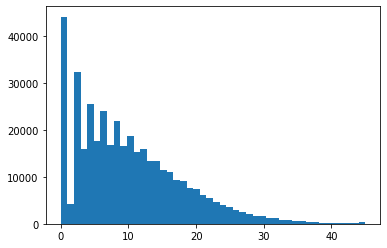

In [25]:
plt.hist(label, bins=46)

# 2 Model Study

## 2.1 Team model

In [ ]:
# instantiate models
folds = 5

model_logistic = LogisticRegression(solver='lbfgs', fit_intercept=True, C=0.1, max_iter=100000, tol=1e-5, random_state=42)

model_m_logistic = OneVsRestClassifier(LogisticRegression(solver='lbfgs', fit_intercept=True, max_iter=5000, 
                                                          tol=1e-3, random_state=42))

# depth of 10 seems better than 15
model_RFC = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=42)

model_ordinal = LogisticAT(alpha=100)  # alpha parameter set to zero to perform no regularisation

model_linear = SGDRegressor(max_iter=1000, tol=1e-3)

model_SGD = SGDClassifier(loss='log', penalty=None, fit_intercept=True, max_iter=10000, tol=1e-4, random_state=42)

model_m_sgd = OneVsRestClassifier(model_SGD)

#model_SVC = LinearSVC(max_iter=10000, tol=1e-4, random_state=42)

model_RFR = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=10, random_state=42)

In [ ]:
def create_DL_model():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[34,]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        #keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        #keras.layers.Dropout(rate=0.2),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(40, activation='softmax')
    ])

    # multi-nomial classification
    #model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['AUC'])

    # binary classification
    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    model_DL.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[['mae']])

    #model_DL.summary()
    
    return model_DL

model_DL_team = KerasClassifier(build_fn=create_DL_model, epochs=20, verbose=0)

In [ ]:
MAE_linear = cross_validate(model_linear,
    features_train,
    label_train,
    cv=folds,
    scoring=['neg_mean_absolute_error'])
print('Linear regression: {:.3f}'.format(-MAE_linear['test_neg_mean_absolute_error'].mean()) )

In [ ]:
# Random forest classification

scores_RFC = cross_validate(model_RFC,
    features_train,
    label_train,
    cv=folds,
    scoring=(['neg_mean_absolute_error']) )
print('Random Forest Classifier (mae): {:.3}'.format(-scores_RFC['test_neg_mean_absolute_error'].mean()) )

In [ ]:
# Random forest classification

scores_RFR = cross_validate(model_RFR,
    features_train,
    label_train,
    cv=folds,
    scoring=(['neg_mean_absolute_error']))
print('Random Forest Regressor (mae): {:.3}'.format(-scores_RFC['test_neg_mean_absolute_error'].mean() ) )

In [ ]:
MAE = make_scorer(mean_absolute_error)

MAE_ordinal = cross_validate(model_ordinal,
    features_train,
    label_train,
    cv=folds,
    scoring=['neg_mean_absolute_error'])
print('Ordered logistic regression (mae): {:.3}'.format(-MAE_ordinal['test_neg_mean_absolute_error'].mean() ) )

In [ ]:
print('Ordered logistic regression (mae/accuracy): {:.3f}, {:.3f}'.format(
                                                    MAE_ordinal['test_neg_mean_absolute_error'].mean(), 
                                                    MAE_ordinal['test_accuracy'].mean()) )

In [ ]:
# does the prediction from ordinal regression fall into the range?

In [ ]:
features_train.shape

In [ ]:
# Deep learning classification

scores_DL = cross_validate(model_DL_team,
    features_train,
    label_train,
    cv=folds,
    scoring=(['neg_mean_absolute_error']))

# print('Win Probability - Random Forest Classifier (P/R/F1/ROC): {:.2%}  {:.2%}  {:.2%} {:.2%}'.format(
#                                                                                 #scores_DL['test_recall'].mean(), 
#                                                                                 #scores_DL['test_precision'].mean(), 
#                                                                                 #scores_DL['test_f1'].mean(),
#                                                                                 0.0,0.0,0.0,
#                                                                                 scores_DL['test_roc_auc'].mean()))

In [ ]:
scores_DL['test_neg_mean_absolute_error'].mean()

In [ ]:
# feature importance study
model_RFC.fit(features_train, label_train)
feature_score = pd.DataFrame([feature_names, model_RFC.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

## 2.2 Player model

#### (1) Model Performance Evaluation

In [514]:
weights = [1.0]*5 + [2.0]*26 + [4.0]*10 + [8.0]*5
w_dic = { ind:w for ind, w in enumerate(weights)}

weights = [1.0]*5 + [2.0]*16 + [4.0]*15 + [8.0]*10
w_dic2 = { ind:w for ind, w in enumerate(weights)}

In [597]:
# instantiate models
folds = 5

# baseline model
model_linear_player = SGDRegressor(max_iter=1000, tol=1e-3)

model_logistic_player = LogisticRegression(solver='lbfgs', fit_intercept=True, C=0.01, max_iter=1000, 
                                           class_weight=None, tol=1e-3, random_state=42)

model_logistic_player_2 = LogisticRegression(solver='lbfgs', fit_intercept=True, C=0.01, max_iter=1000, 
                                           class_weight=w_dic, tol=1e-3, random_state=42)

model_logistic_player_3 = LogisticRegression(solver='lbfgs', fit_intercept=True, C=0.01, max_iter=1000, 
                                           class_weight=w_dic2, tol=1e-3, random_state=42)

model_RFC_player = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_leaf=5, 
                                          class_weight=None, random_state=42)

model_RFC_player_2 = RandomForestClassifier(n_estimators=100, max_depth=9, min_samples_leaf=5, 
                                          class_weight=w_dic, random_state=42)

model_ordinal_player = LogisticAT(alpha=1)  # alpha parameter set to zero to perform no regularisation

# fast calculation but no probability outputs
model_ordinal_player_2 = LAD()

In [393]:
def maee_loss_func(y_true, y_pred):
    diff = np.dot(y_pred, np.array(range(46))) - y_true
    return np.abs(diff)

def msee_loss_func(y_true, y_pred):
    diff = np.dot(y_pred, np.array(range(46))) - y_true
    return np.square(diff)

maee_loss = make_scorer(maee_loss_func, greater_is_better=False)
msee_loss = make_scorer(msee_loss_func, greater_is_better=False)

In [521]:
def create_DL_model_1():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[27,]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        #keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        #keras.layers.Dropout(rate=0.2),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(46, activation='softmax')
    ])

    optimizer = keras.optimizers.SGD(learning_rate=0.005, decay=1e-4)
    model_DL.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=[['mae','mse']])

    #model_DL.summary()
    
    return model_DL

def create_DL_model_w():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[27,]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        #keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        #keras.layers.Dropout(rate=0.2),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(46, activation='softmax')
    ])

    optimizer = keras.optimizers.SGD(learning_rate=0.005, decay=1e-4)
    model_DL.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizer, metrics=[['mae','mse']])

    #model_DL.summary()
    #print(model_DL.summary())
    
    return model_DL

def mae_crossentropy(y_true, y_pred):
    K = y_pred.shape[1].value
    
    se = tf.square(np.array(range(K)).astype(np.float32) - y_true  )

    one_cost = tf.reduce_mean( se * tf.pow(y_pred, 2), axis=1 )

    return one_cost

def create_DL_model_cus():
    model_DL = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[27,]),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        #keras.layers.Dense(250, activation='elu', kernel_initializer="he_normal"),
        #keras.layers.Dropout(rate=0.2),
        #keras.layers.BatchNormalization(),
        keras.layers.Dense(150, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(80, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(30, activation='elu', kernel_initializer="he_normal"),
        keras.layers.Dropout(rate=0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(46, activation='softmax')
    ])

    optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)
    
    model_DL.compile(loss=mae_crossentropy, optimizer=optimizer, metrics=[['mae','mse']])
    
    return model_DL

In [464]:
MAE_linear_player = cross_validate(model_linear_player,
                                    features_train_player,
                                    label_train_player,
                                    cv=folds,
                                    scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])
print('Linear regression (mae/rmse/P/R/F1/ROC): {:.3f} {:.3f}'.format(
                                                -MAE_linear_player['test_neg_mean_absolute_error'].mean(),
                                                -MAE_linear_player['test_neg_root_mean_squared_error'].mean()
                                                ) )

Linear regression (mae/rmse/P/R/F1/ROC): 4.376 5.656


In [467]:
# For classification, how to add distribution evaluation? pre-eval, quantile plot?
scores_logistic_player = cross_validate(model_logistic_player,
                                        features_train_player,
                                        label_train_player,
                                        cv=folds,
                                        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                                 'recall_micro','precision_micro',
                                                 'f1_micro','roc_auc_ovr_weighted'])
print('logistic classifier (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_logistic_player['test_neg_mean_absolute_error'].mean(),
                                                -scores_logistic_player['test_neg_root_mean_squared_error'].mean(),
                                                scores_logistic_player['test_recall_micro'].mean(), 
                                                scores_logistic_player['test_precision_micro'].mean(), 
                                                scores_logistic_player['test_f1_micro'].mean(),
                                                scores_logistic_player['test_roc_auc_ovr_weighted'].mean()) )

logistic classifier (mae/rmse): 4.979 6.676 0.144 0.144 0.144 0.722


In [487]:
# For classification, how to add distribution evaluation? pre-eval, quantile plot?
scores_logistic_player_2 = cross_validate(model_logistic_player_2,
                                        features_train_player,
                                        label_train_player,
                                        cv=folds,
                                        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                                 'recall_micro','precision_micro',
                                                 'f1_micro','roc_auc_ovr_weighted'])
print('logistic classifier (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_logistic_player_2['test_neg_mean_absolute_error'].mean(),
                                                -scores_logistic_player_2['test_neg_root_mean_squared_error'].mean(),
                                                scores_logistic_player_2['test_recall_micro'].mean(), 
                                                scores_logistic_player_2['test_precision_micro'].mean(), 
                                                scores_logistic_player_2['test_f1_micro'].mean(),
                                                scores_logistic_player_2['test_roc_auc_ovr_weighted'].mean()) )

logistic classifier (mae/rmse): 4.730 6.451 0.138 0.138 0.138 0.719


In [472]:
# For classification, how to add distribution evaluation? pre-eval, quantile plot?
scores_logistic_player_3 = cross_validate(model_logistic_player_3,
                                            features_train_player,
                                            label_train_player,
                                            cv=folds,
                                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                                     'recall_micro','precision_micro',
                                                     'f1_micro','roc_auc_ovr_weighted'])
print('logistic classifier (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_logistic_player_3['test_neg_mean_absolute_error'].mean(),
                                                -scores_logistic_player_3['test_neg_root_mean_squared_error'].mean(),
                                                scores_logistic_player_3['test_recall_micro'].mean(), 
                                                scores_logistic_player_3['test_precision_micro'].mean(), 
                                                scores_logistic_player_3['test_f1_micro'].mean(),
                                                scores_logistic_player_3['test_roc_auc_ovr_weighted'].mean()) )

logistic classifier (mae/rmse): 4.818 6.499 0.136 0.136 0.136 0.717


In [473]:
scores_ordinal = cross_validate(model_ordinal_player,
                                features_train_player,
                                label_train_player,
                                cv=folds,       
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                        'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'])
print('Ordered logistic regression (mae): {:.3} {:.3}'.format(
                                                -scores_ordinal['test_neg_mean_absolute_error'].mean(),
                                                -scores_ordinal['test_neg_root_mean_squared_error'].mean(),
                                                scores_ordinal['test_recall_micro'].mean(), 
                                                scores_ordinal['test_precision_micro'].mean(), 
                                                scores_ordinal['test_f1_micro'].mean(),
                                                scores_ordinal['test_roc_auc_ovr_weighted'].mean()) )

KeyboardInterrupt: 

In [188]:
# this is much faster than LogisticAT, but it doesn't provide prob distribution
scores_ordinal_2 = cross_validate(model_ordinal_player_2,
                                features_train_player,
                                label_train_player,
                                cv=folds,       
                                scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error'])
print('Ordered logistic regression (mae): {:.3} {:.3}'.format(
                                                -scores_ordinal_2['test_neg_mean_absolute_error'].mean(),
                                                -scores_ordinal_2['test_neg_root_mean_squared_error'].mean()) )

Ordered logistic regression (mae): 4.31 5.67


In [598]:
# Random forest classification

scores_RFC = cross_validate(model_RFC_player,
                            features_train_player,
                            label_train_player,
                            cv=folds,
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                    'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'])
print('Random Forest Classifier (mae): {:.3} {:.3} {:.3} {:.3} {:.3} {:.3}'.format(
                                                -scores_RFC['test_neg_mean_absolute_error'].mean(),
                                                -scores_RFC['test_neg_root_mean_squared_error'].mean()),
                                                scores_RFC['test_recall_micro'].mean(), 
                                                scores_RFC['test_precision_micro'].mean(), 
                                                scores_RFC['test_f1_micro'].mean(),
                                                scores_RFC['test_roc_auc_ovr_weighted'].mean())

IndexError: tuple index out of range

In [475]:
# Random forest classification

scores_RFC_2 = cross_validate(model_RFC_player_2,
                            features_train_player,
                            label_train_player,
                            cv=folds,
                            scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                    'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'])
print('Random Forest Classifier (mae): {:.3} {:.3} {:.3} {:.3} {:.3} {:.3}'.format(
                                                -scores_RFC_2['test_neg_mean_absolute_error'].mean(),
                                                -scores_RFC_2['test_neg_root_mean_squared_error'].mean()),
                                                scores_RFC_2['test_recall_micro'].mean(), 
                                                scores_RFC_2['test_precision_micro'].mean(), 
                                                scores_RFC_2['test_f1_micro'].mean(),
                                                scores_RFC_2['test_roc_auc_ovr_weighted'].mean())

Random Forest Classifier (mae): 4.72 6.42 0.1379092744529087 0.1379092744529087 0.1379092744529087 0.7185576736235997


In [489]:
#X_train, y_train, = shuffle(features_train_player, label_train_player, random_state=42)

model_DL_player_1 = KerasClassifier(build_fn=create_DL_model_1, epochs=30, verbose=1, shuffle=True)
scores_DL_player_1 = cross_validate(model_DL_player_1,
                                    features_train_player,
                                    label_train_player,
                                    cv=5,
                                    scoring=(['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                              'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'
                                             ]) )

Epoch 1/30
281495/281495 [==============================] - 63s 223us/sample - loss: 3.2335 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4962
Epoch 2/30
281495/281495 [==============================] - 53s 188us/sample - loss: 2.9999 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4968
Epoch 3/30
281495/281495 [==============================] - 54s 191us/sample - loss: 2.9783 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4965
Epoch 4/30
281495/281495 [==============================] - 56s 198us/sample - loss: 2.9681 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4963
Epoch 5/30
281495/281495 [==============================] - 54s 191us/sample - loss: 2.9629 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4964
Epoch 6/30
281495/281495 [==============================] - 53s 188us/sample - loss: 2.9601 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4964
Epoch 7/30
281495/281495 [==============================] - 57s 201us/sample - los

In [490]:
print('DNN (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_DL_player_1['test_neg_mean_absolute_error'].mean(),
                                                -scores_DL_player_1['test_neg_root_mean_squared_error'].mean(),
                                                scores_DL_player_1['test_recall_micro'].mean(), 
                                                scores_DL_player_1['test_precision_micro'].mean(), 
                                                scores_DL_player_1['test_f1_micro'].mean(),
                                                scores_DL_player_1['test_roc_auc_ovr_weighted'].mean()) )

DNN (mae/rmse): 5.122 6.822 0.142 0.142 0.142 0.720


In [496]:
#X_train, y_train, = shuffle(features_train_player, label_train_player, random_state=42)

model_DL_player_2 = KerasClassifier(build_fn=create_DL_model_w, epochs=30, verbose=1, shuffle=True)
scores_DL_player_2 = cross_validate(model_DL_player_2,
                                    features_train_player,
                                    label_train_player,
                                    fit_params={'class_weight':w_dic},
                                    cv=5,
                                    scoring=(['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                              'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'
                                             ]) )

KeyboardInterrupt: 

In [497]:
print('DNN (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_DL_player_2['test_neg_mean_absolute_error'].mean(),
                                                -scores_DL_player_2['test_neg_root_mean_squared_error'].mean(),
                                                scores_DL_player_2['test_recall_micro'].mean(), 
                                                scores_DL_player_2['test_precision_micro'].mean(), 
                                                scores_DL_player_2['test_f1_micro'].mean(),
                                                scores_DL_player_2['test_roc_auc_ovr_weighted'].mean()) )

DNN (mae/rmse): 4.722 6.393 0.139 0.139 0.139 0.716


In [524]:
model_DL_player_cus_1 = KerasClassifier(build_fn=create_DL_model_cus, epochs=30, verbose=1, shuffle=True)
scores_DL_player_cus_1 = cross_validate(model_DL_player_cus,
                                    features_train_player,
                                    label_train_player,
                                    #fit_params={'class_weight':w_dic},
                                    cv=5,
                                    scoring=(['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                              'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'
                                             ]) )

Epoch 1/30
281495/281495 [==============================] - 58s 207us/sample - loss: 0.1317 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4953
Epoch 2/30
281495/281495 [==============================] - 59s 209us/sample - loss: 0.0816 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4953
Epoch 3/30
281495/281495 [==============================] - 59s 210us/sample - loss: 0.0715 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4953
Epoch 4/30
281495/281495 [==============================] - 57s 203us/sample - loss: 0.0671 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4958
Epoch 5/30
281495/281495 [==============================] - 59s 210us/sample - loss: 0.0647 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4955
Epoch 6/30
281495/281495 [==============================] - 59s 208us/sample - loss: 0.0632 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4952
Epoch 7/30
281495/281495 [==============================] - 58s 207us/sample - los

In [525]:
print('DNN (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_DL_player_cus_1['test_neg_mean_absolute_error'].mean(),
                                                -scores_DL_player_cus_1['test_neg_root_mean_squared_error'].mean(),
                                                scores_DL_player_cus_1['test_recall_micro'].mean(), 
                                                scores_DL_player_cus_1['test_precision_micro'].mean(), 
                                                scores_DL_player_cus_1['test_f1_micro'].mean(),
                                                scores_DL_player_cus_1['test_roc_auc_ovr_weighted'].mean()) )

DNN (mae/rmse): 4.508 5.881 0.069 0.069 0.069 0.694


In [522]:
model_DL_player_cus = KerasClassifier(build_fn=create_DL_model_cus, epochs=30, verbose=1, shuffle=True)
scores_DL_player_cus = cross_validate(model_DL_player_cus,
                                    features_train_player,
                                    label_train_player,
                                    fit_params={'class_weight':w_dic},
                                    cv=5,
                                    scoring=(['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                                              'recall_micro','precision_micro','f1_micro','roc_auc_ovr_weighted'
                                             ]) )

Epoch 1/30
281495/281495 [==============================] - 59s 209us/sample - loss: 0.1855 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4950
Epoch 2/30
281495/281495 [==============================] - 59s 208us/sample - loss: 0.1212 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4953
Epoch 3/30
281495/281495 [==============================] - 58s 205us/sample - loss: 0.1131 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4954
Epoch 4/30
281495/281495 [==============================] - 60s 214us/sample - loss: 0.1102 - mean_absolute_error: 9.6562 - mean_squared_error: 154.4956
Epoch 5/30
281495/281495 [==============================] - 60s 213us/sample - loss: 0.1081 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4952
Epoch 6/30
281495/281495 [==============================] - 59s 210us/sample - loss: 0.1071 - mean_absolute_error: 9.6563 - mean_squared_error: 154.4953
Epoch 7/30
281495/281495 [==============================] - 58s 205us/sample - los

In [523]:
print('DNN (mae/rmse): {:.3f} {:.3f} {:.3f} {:.3f} {:.3f} {:.3f}'.format(
                                                -scores_DL_player_cus['test_neg_mean_absolute_error'].mean(),
                                                -scores_DL_player_cus['test_neg_root_mean_squared_error'].mean(),
                                                scores_DL_player_cus['test_recall_micro'].mean(), 
                                                scores_DL_player_cus['test_precision_micro'].mean(), 
                                                scores_DL_player_cus['test_f1_micro'].mean(),
                                                scores_DL_player_cus['test_roc_auc_ovr_weighted'].mean()) )

DNN (mae/rmse): 4.632 5.830 0.063 0.063 0.063 0.688


In [637]:
model_logistic_player.fit(features_train_player, label_train_player)
model_logistic_player_2.fit(features_train_player, label_train_player)

model_DL_player_1 = KerasClassifier(build_fn=create_DL_model_1, epochs=30, verbose=1, shuffle=True)
model_DL_player_1.fit(features_train_player, label_train_player)

model_DL_player_w = KerasClassifier(build_fn=create_DL_model_w, epochs=30,  verbose=1, shuffle=True)
model_DL_player_w.fit(features_train_player, label_train_player, class_weight=w_dic)

model_DL_player_cus_1 = KerasClassifier(build_fn=create_DL_model_cus, epochs=30, verbose=1, shuffle=True)
model_DL_player_cus_1.fit(features_train_player, label_train_player)

model_RFC_player.fit(features_train_player, label_train_player)
model_RFC_player_2.fit(features_train_player, label_train_player)

model_linear_player.fit(features_train_player, label_train_player)

model_ordinal_player.fit(features_train_player, label_train_player)

Epoch 1/30
351869/351869 [==============================] - 86s 243us/sample - loss: 3.2098 - mean_absolute_error: 9.7098 - mean_squared_error: 157.3004
Epoch 2/30
351869/351869 [==============================] - 84s 238us/sample - loss: 2.9951 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2999
Epoch 3/30
351869/351869 [==============================] - 84s 239us/sample - loss: 2.9764 - mean_absolute_error: 9.7097 - mean_squared_error: 157.3001
Epoch 4/30
351869/351869 [==============================] - 81s 232us/sample - loss: 2.9684 - mean_absolute_error: 9.7098 - mean_squared_error: 157.3004
Epoch 5/30
351869/351869 [==============================] - 85s 242us/sample - loss: 2.9637 - mean_absolute_error: 9.7098 - mean_squared_error: 157.3001
Epoch 6/30
351869/351869 [==============================] - 83s 235us/sample - loss: 2.9611 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2998
Epoch 7/30
351869/351869 [==============================] - 82s 233us/sample - los

LogisticAT(alpha=1)

In [713]:
#model_logistic_player_2.fit(features_train_player, label_train_player)

dump(model_logistic_player_2, 'model_logistic.joblib')

['model_logistic.joblib']

In [626]:
#pred_1 = model_linear_player.predict(features_train_player)

pred_1 = model_logistic_player.predict_proba(features_train_player)
pred_1 = np.dot(pred_1, np.array(range(46)) )

pred_2 = model_logistic_player_2.predict_proba(features_train_player)
pred_2 = np.dot(pred_2, np.array(range(46)) )

pred_3 = model_RFC_player.predict_proba(features_train_player)
pred_3 = np.dot(pred_3, np.array(range(46)) )

pred_4 = model_RFC_player_2.predict_proba(features_train_player)
pred_4 = np.dot(pred_4, np.array(range(46)) )

pred_5 = model_DL_player_1.predict_proba(features_train_player)
pred_5 = np.dot(pred_5, np.array(range(46)) )

pred_6 = model_DL_player_2.predict_proba(features_train_player)
pred_6 = np.dot(pred_6, np.array(range(46)) )

pred_7 = model_DL_player_cus.predict_proba(features_train_player)
pred_7 = np.dot(pred_7, np.array(range(46)) )

pred_8 = model_linear_player.predict(features_train_player)


NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

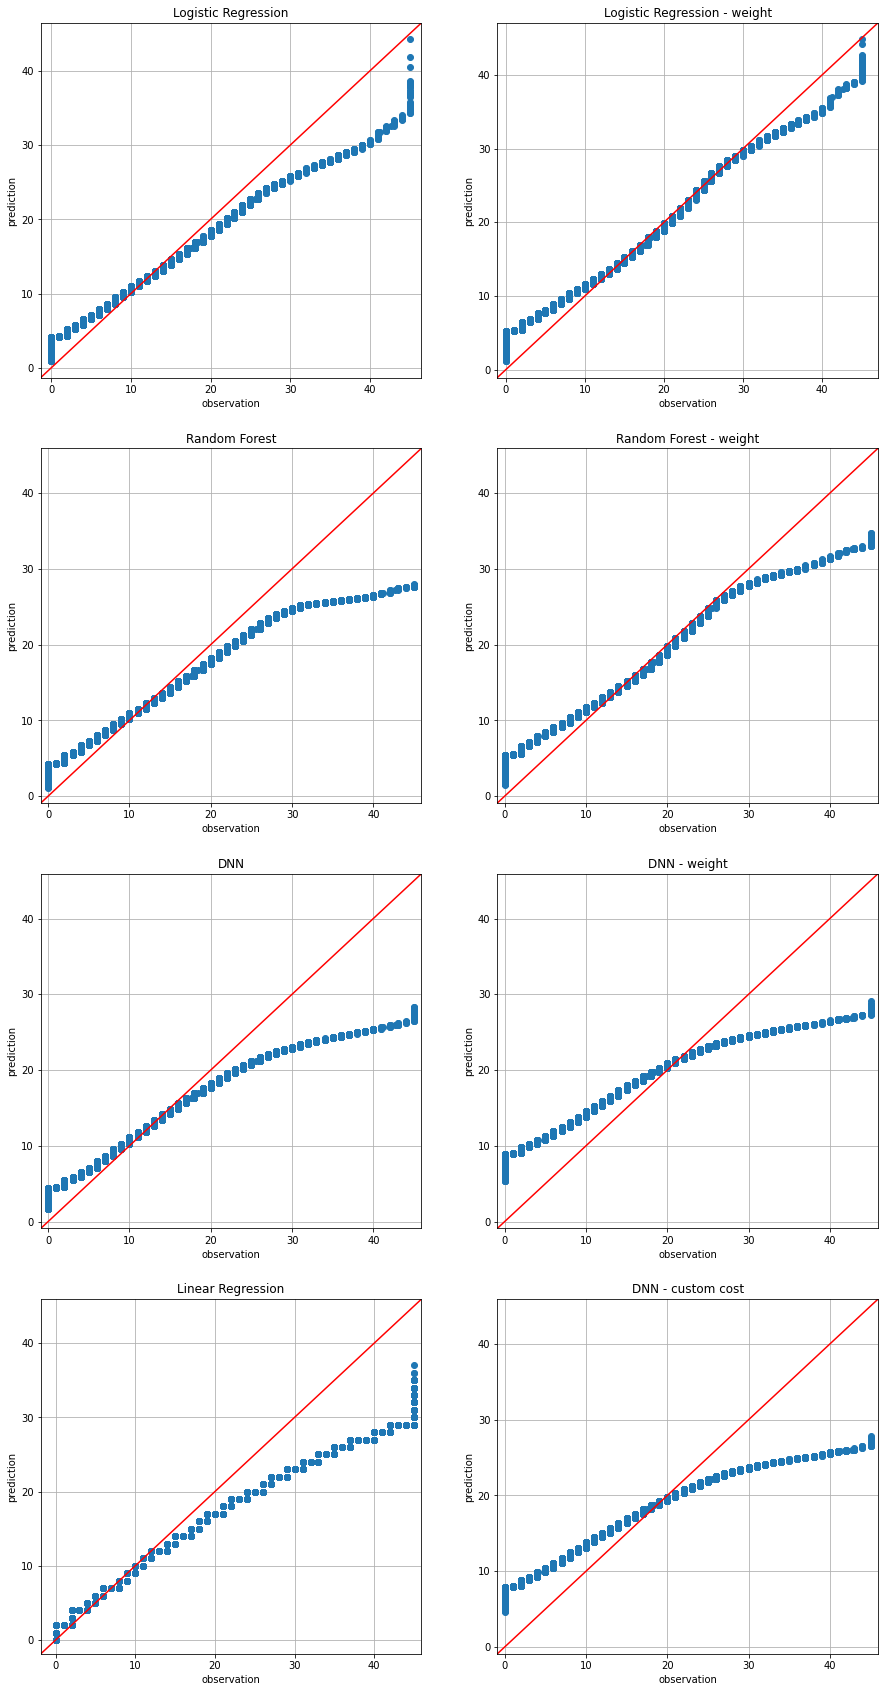

In [624]:
fig, axs = plt.subplots(4,2) #, sharey=True)
fig.set_size_inches(15,30)

qqplot_2samples(pred_1, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[0,0])
axs[0,0].title.set_text('Logistic Regression')
axs[0,0].grid()

qqplot_2samples(pred_2, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[0,1])
axs[0,1].title.set_text('Logistic Regression - weight')
axs[0,1].grid()

qqplot_2samples(pred_3, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[1,0])
axs[1,0].title.set_text('Random Forest')
axs[1,0].grid()

qqplot_2samples(pred_4, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[1,1])
axs[1,1].title.set_text('Random Forest - weight')
axs[1,1].grid()

qqplot_2samples(pred_5, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[2,0])
axs[2,0].title.set_text('DNN')
axs[2,0].grid()

qqplot_2samples(pred_6, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[2,1])
axs[2,1].title.set_text('DNN - weight')
axs[2,1].grid()

qqplot_2samples(pred_7, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[3,1])
axs[3,1].title.set_text('DNN - custom cost')
axs[3,1].grid()

qqplot_2samples(pred_8, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[3,0])
axs[3,0].title.set_text('Linear Regression')
axs[3,0].grid()

plt.show()

In [591]:
# calculate in-sample mse and mae
# seems in-sample the fitted error is larger for weighted classification
labels = label_train_player
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_1), np.sqrt(mean_squared_error(labels, pred_1))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_2), np.sqrt(mean_squared_error(labels, pred_2))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_3), np.sqrt(mean_squared_error(labels, pred_3))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_4), np.sqrt(mean_squared_error(labels, pred_4))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_5), np.sqrt(mean_squared_error(labels, pred_5))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_6), np.sqrt(mean_squared_error(labels, pred_6))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_7), np.sqrt(mean_squared_error(labels, pred_7))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_8), np.sqrt(mean_squared_error(labels, pred_8))))

4.284 5.554
4.464 5.658
4.288 5.548
4.483 5.648
4.336 5.598
5.745 6.819
5.270 6.344
4.375 5.650


In [592]:
# calculate in-sample mse and mae
# seems in-sample the fitted error is larger for weighted classification

id = label_train_player >= 30

labels = label_train_player

print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_1[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_1[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_2[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_2[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_3[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_3[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_4[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_4[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_5[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_5[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_6[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_6[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_7[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_7[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_8[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_8[id]))))

13.100 14.170
10.992 12.526
13.716 14.664
11.512 12.893
14.407 15.169
12.145 12.935
13.239 13.963
14.435 15.187


(array([0.0000e+00, 9.9000e+02, 7.8460e+03, 1.7095e+04, 2.3988e+04,
        2.7210e+04, 2.8866e+04, 2.8217e+04, 2.7006e+04, 2.5115e+04,
        2.3492e+04, 2.1138e+04, 1.8640e+04, 1.6068e+04, 1.4032e+04,
        1.2058e+04, 1.0373e+04, 8.7940e+03, 7.4210e+03, 6.1320e+03,
        5.2350e+03, 4.2200e+03, 3.4590e+03, 2.6550e+03, 2.1680e+03,
        1.9420e+03, 1.6850e+03, 1.3690e+03, 1.1870e+03, 9.9000e+02,
        7.7200e+02, 5.5800e+02, 4.5200e+02, 2.9500e+02, 1.6600e+02,
        1.1600e+02, 6.4000e+01, 3.4000e+01, 1.2000e+01, 8.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),
 <BarContainer object of 45 artists>)

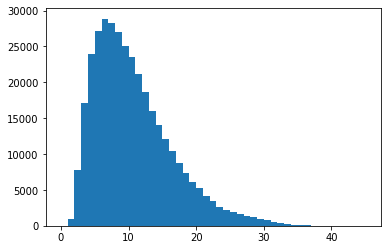

In [587]:
plt.hist(pred_2, bins=range(46))

In [569]:
# feature importance study
model_RFC_player.fit(features_train_player, label_train_player)
feature_score = pd.DataFrame([feature_names_player, model_RFC_player.feature_importances_], index=['feature','importance']).transpose()
feature_score.sort_values(by='importance', ascending=False)

,feature,importance
0,minutes_l10,0.332924
1,points_l10,0.11793
26,game_started_True,0.101099
25,game_started_False,0.093295
3,fg_made_l10,0.074365
2,fg_attempt_l10,0.069052
5,ft_made_l10,0.032856
7,point_3_made_l10,0.028315
4,ft_attempt_l10,0.026661
6,point_3_attempt_l10,0.025433


#### (2) In-sample Probability Plot

# 3 Model Prediction

## 3.1 Prediction for 2018 season

In [339]:
model_linear_player.fit(features_train_player, label_train_player)

SGDRegressor()

In [354]:
w = [0.5]*5 + [1.0]*26 + [2.0]*10 + [4.0]*5
w_dic = { ind:j for ind, j in enumerate(w)}

In [355]:
model_logistic_player = LogisticRegression(solver='lbfgs', fit_intercept=True, C=0.01, max_iter=1000, 
                                           class_weight=w_dic, tol=1e-3, random_state=42)

model_logistic_player.fit(features_train_player, label_train_player)

LogisticRegression(C=0.01,
                   class_weight={0: 0.5, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 1.0,
                                 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0,
                                 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0,
                                 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0,
                                 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0,
                                 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, ...},
                   max_iter=1000, random_state=42, tol=0.001)

In [ ]:
model_ordinal_player.fit(features_train_player, label_train_player)

In [268]:
model_ordinal_player_2.fit(features_train_player, label_train_player)

LAD()

In [406]:
model_DL_player_1 = KerasClassifier(build_fn=create_DL_model_1, epochs=40, verbose=1)

model_DL_player_1.fit(features_train_player, label_train_player, class_weight=w_dic)

Epoch 1/40
351869/351869 [==============================] - 56s 158us/sample - loss: 2.9198 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2992
Epoch 2/40
351869/351869 [==============================] - 52s 149us/sample - loss: 2.7220 - mean_absolute_error: 9.7097 - mean_squared_error: 157.3006
Epoch 3/40
351869/351869 [==============================] - 53s 150us/sample - loss: 2.7022 - mean_absolute_error: 9.7098 - mean_squared_error: 157.3000
Epoch 4/40
351869/351869 [==============================] - 53s 150us/sample - loss: 2.6940 - mean_absolute_error: 9.7097 - mean_squared_error: 157.2995
Epoch 5/40
351869/351869 [==============================] - 54s 152us/sample - loss: 2.6890 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2998
Epoch 6/40
351869/351869 [==============================] - 54s 153us/sample - loss: 2.6873 - mean_absolute_error: 9.7098 - mean_squared_error: 157.3002
Epoch 7/40
351869/351869 [==============================] - 54s 153us/sample - los

In [518]:
X_train, y_train, = shuffle(features_train_player, label_train_player, random_state=42)

model_DL_player_2 = KerasClassifier(build_fn=create_DL_model_2, epochs=20, verbose=1)

model_DL_player_2.fit(X_train, y_train, class_weight=w_dic)

Epoch 1/20
351869/351869 [==============================] - 71s 203us/sample - loss: 0.1743 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2991
Epoch 2/20
351869/351869 [==============================] - 73s 207us/sample - loss: 0.1195 - mean_absolute_error: 9.7097 - mean_squared_error: 157.2990
Epoch 3/20
351869/351869 [==============================] - 72s 206us/sample - loss: 0.1130 - mean_absolute_error: 9.7097 - mean_squared_error: 157.2989
Epoch 4/20
351869/351869 [==============================] - 72s 203us/sample - loss: 0.1103 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2994
Epoch 5/20
351869/351869 [==============================] - 59s 168us/sample - loss: 0.1091 - mean_absolute_error: 9.7098 - mean_squared_error: 157.2992
Epoch 6/20
351869/351869 [==============================] - 64s 182us/sample - loss: 0.1080 - mean_absolute_error: 9.7097 - mean_squared_error: 157.2993
Epoch 7/20
351869/351869 [==============================] - 56s 159us/sample - los

In [632]:
pred_1 = model_logistic_player.predict_proba(features_test_player)
pred_1 = np.dot(pred_1, np.array(range(46)) )

pred_2 = model_logistic_player_2.predict_proba(features_test_player)
pred_2 = np.dot(pred_2, np.array(range(46)) )

pred_3 = model_RFC_player.predict_proba(features_test_player)
pred_3 = np.dot(pred_3, np.array(range(46)) )

pred_4 = model_RFC_player_2.predict_proba(features_test_player)
pred_4 = np.dot(pred_4, np.array(range(46)) )

pred_5 = model_DL_player_1.predict_proba(features_test_player)
pred_5 = np.dot(pred_5, np.array(range(46)) )

pred_6 = model_DL_player_2.predict_proba(features_test_player)
pred_6 = np.dot(pred_6, np.array(range(46)) )

pred_7 = model_DL_player_cus.predict_proba(features_test_player)
pred_7 = np.dot(pred_7, np.array(range(46)) )

pred_8 = model_linear_player.predict(features_test_player)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

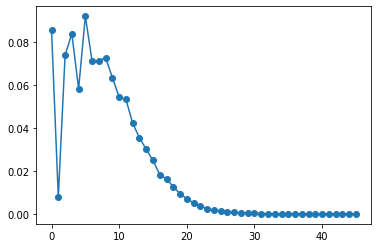

In [647]:
plt.plot((model_logistic_player.predict_proba(features_test_player[2:3,:]))[0],marker='o')

In [633]:
#model_ordinal_player.fit(features_train_player, label_train_player)

pred_9 = model_ordinal_player.predict_proba(features_test_player)
pred_9 = np.dot(pred_9, np.array(range(46)) )

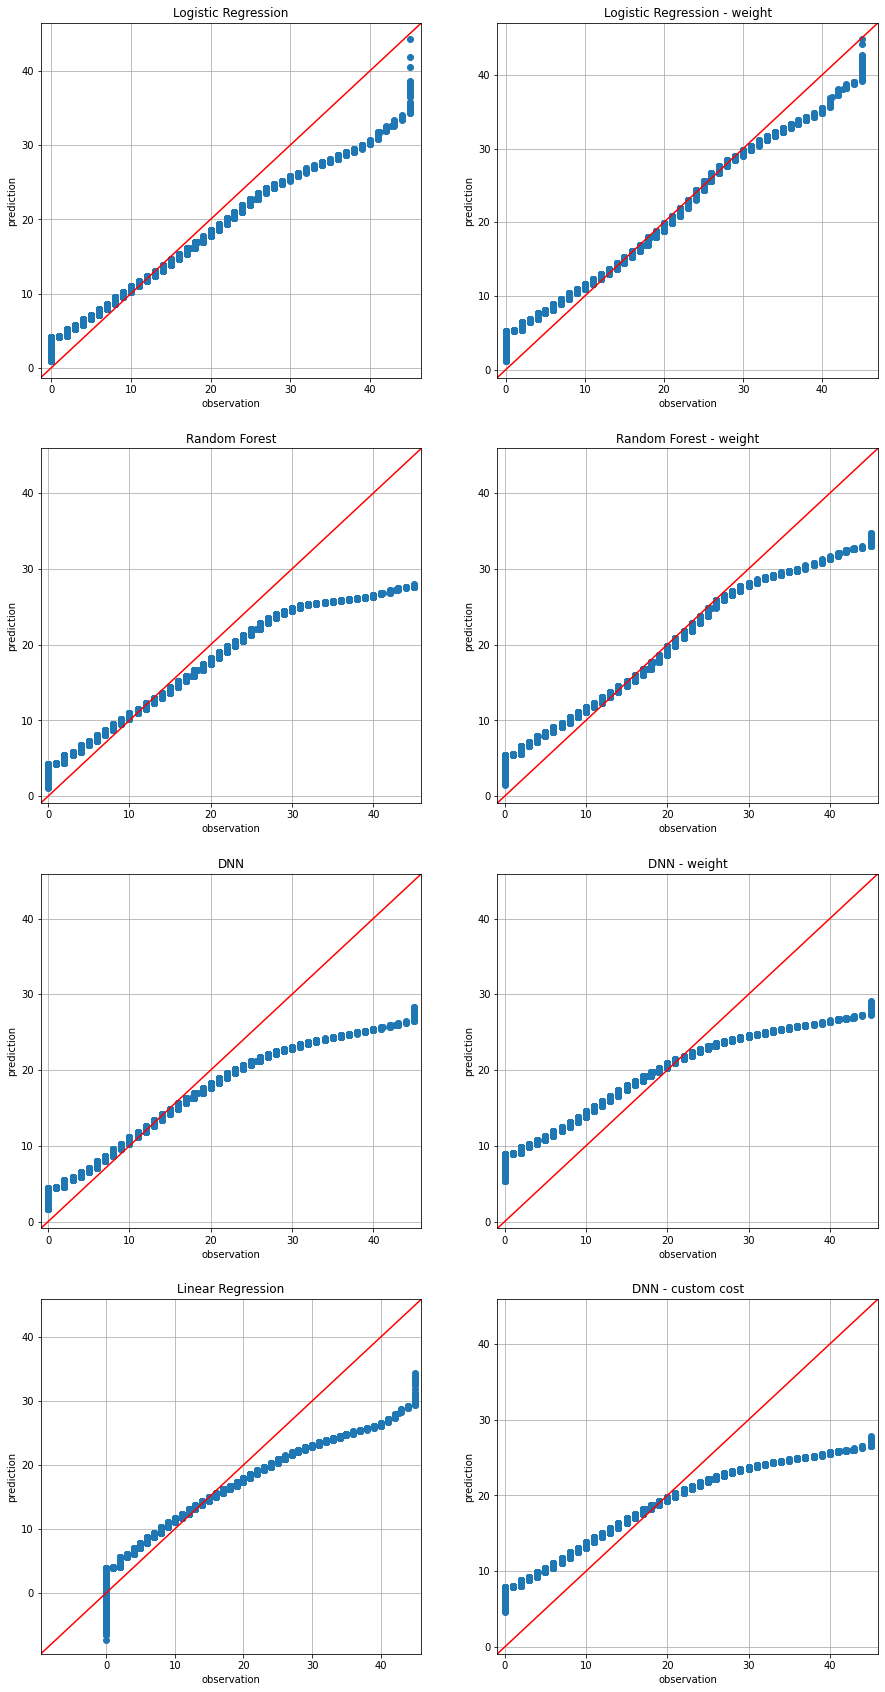

In [594]:
fig, axs = plt.subplots(4,2) #, sharey=True)
fig.set_size_inches(15,30)

qqplot_2samples(pred_1, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[0,0])
axs[0,0].title.set_text('Logistic Regression')
axs[0,0].grid()

qqplot_2samples(pred_2, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[0,1])
axs[0,1].title.set_text('Logistic Regression - weight')
axs[0,1].grid()

qqplot_2samples(pred_3, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[1,0])
axs[1,0].title.set_text('Random Forest')
axs[1,0].grid()

qqplot_2samples(pred_4, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[1,1])
axs[1,1].title.set_text('Random Forest - weight')
axs[1,1].grid()

qqplot_2samples(pred_5, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[2,0])
axs[2,0].title.set_text('DNN')
axs[2,0].grid()

qqplot_2samples(pred_6, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[2,1])
axs[2,1].title.set_text('DNN - weight')
axs[2,1].grid()

qqplot_2samples(pred_7, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[3,1])
axs[3,1].title.set_text('DNN - custom cost')
axs[3,1].grid()

qqplot_2samples(pred_8, label_train_player, xlabel='observation', ylabel='prediction', line='45', ax=axs[3,0])
axs[3,0].title.set_text('Linear Regression')
axs[3,0].grid()

plt.show()

In [595]:
labels = label_test_player
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_1), np.sqrt(mean_squared_error(labels, pred_1))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_2), np.sqrt(mean_squared_error(labels, pred_2))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_3), np.sqrt(mean_squared_error(labels, pred_3))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_4), np.sqrt(mean_squared_error(labels, pred_4))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_5), np.sqrt(mean_squared_error(labels, pred_5))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_6), np.sqrt(mean_squared_error(labels, pred_6))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_7), np.sqrt(mean_squared_error(labels, pred_7))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels, pred_8), np.sqrt(mean_squared_error(labels, pred_8))))

4.455 5.779
4.630 5.900
4.463 5.777
4.633 5.852
4.510 5.820
5.811 6.955
5.375 6.516
4.546 5.860


In [629]:
# calculate in-sample mse and mae
# seems in-sample the fitted error is larger for weighted classification

id = label_test_player >= 20

labels = label_test_player

print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_1[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_1[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_2[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_2[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_3[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_3[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_4[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_4[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_5[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_5[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_6[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_6[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_7[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_7[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_8[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_8[id]))))

7.903 9.435
7.165 8.629
8.208 9.755
7.151 8.675
8.293 9.834
6.065 7.681
6.800 8.382


IndexError: boolean index did not match indexed array along dimension 0; dimension is 351869 but corresponding boolean dimension is 41590

In [596]:
# calculate in-sample mse and mae
# seems in-sample the fitted error is larger for weighted classification

id = label_test_player >= 30

labels = label_test_player

print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_1[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_1[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_2[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_2[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_3[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_3[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_4[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_4[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_5[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_5[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_6[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_6[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_7[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_7[id]))))
print("{:.3f} {:.3f}".format(mean_absolute_error(labels[id], pred_8[id]), 
                             np.sqrt(mean_squared_error(labels[id], pred_8[id]))))

12.173 13.353
9.734 11.415
13.222 14.209
10.602 12.069
13.964 14.775
11.900 12.737
12.873 13.656
13.829 14.662


## 3.2 Case study: James Harden (395388) for 2018 season

In [50]:
label_train_player.describe()
type(pred)
import scipy as sc
sc.stats.describe(pred)

DescribeResult(nobs=41590, minmax=(-7.267896859533691, 35.17039750318031), mean=10.456535467435435, variance=32.00646500768804, skewness=0.39008151590104734, kurtosis=-0.17558580043469352)

In [742]:
# James Harden
id = player_df.loc[id_test,'player_id'] == 395388

In [743]:
np.mean(label_test_player[id])

34.76923076923077

In [740]:
model_logistic_player_2.fit(features_train_player, label_train_player)

LogisticRegression(C=0.01,
                   class_weight={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0,
                                 6: 2.0, 7: 2.0, 8: 2.0, 9: 2.0, 10: 2.0,
                                 11: 2.0, 12: 2.0, 13: 2.0, 14: 2.0, 15: 2.0,
                                 16: 2.0, 17: 2.0, 18: 2.0, 19: 2.0, 20: 2.0,
                                 21: 2.0, 22: 2.0, 23: 2.0, 24: 2.0, 25: 2.0,
                                 26: 2.0, 27: 2.0, 28: 2.0, 29: 2.0, ...},
                   max_iter=1000, random_state=42, tol=0.001)

In [744]:
pred_p = model_logistic_player_2.predict_proba(pd.DataFrame(features_test_player)[id.values])
pred = np.dot(pred_p, np.array(range(46)))
np.mean(pred)

38.10954931319682

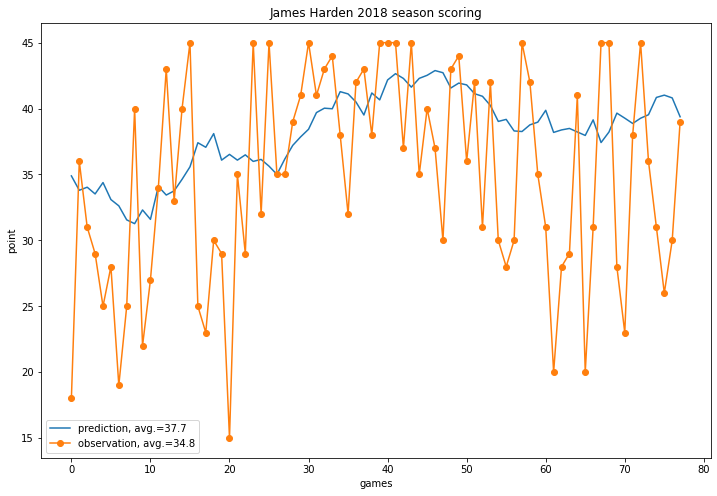

In [745]:
plt.figure(figsize=(12,8))
plt.plot(pred, label='prediction, avg.=37.7')
plt.plot(list(label_test_player[id.values]), linestyle='-', marker='o', label='observation, avg.=34.8')
plt.xlabel('games')
plt.ylabel('point')
plt.title('James Harden 2018 season scoring')
plt.legend()
plt.show()

In [ ]:
# given Harden's 20th game performance: team driver and player driver fixed, while elo-driver keeps moving

In [ ]:
# what if harden moves to Chicago Bulls (team_id==4) in East league
# keep the same team strength

In [305]:
pd.DataFrame(features_test_player)[id.values].iloc[:1,:13]

,0,1,2,3,4,5,6,7,8,9,10,11,12
4788,1.28051,3.389114,2.443958,2.09389,3.373094,3.870637,2.763879,2.558563,-0.785072,0.115877,2.76413,-0.045813,2.548767


In [609]:
# fix player features at the beginning of the season
test_1 = pd.DataFrame(features_test_player)[id.values]
test_1.iloc[:,:13] = test_1.iloc[0,:13]
test_1.shape

(78, 27)

In [610]:
# a Chicago Bull's player
id2 = player_df.loc[id_test,'player_id'] == 330050

test_2 = pd.DataFrame(features_test_player)[id2.values]
test_2.iloc[:,:13] = test_1.iloc[0,:13]
test_2.shape

(74, 27)

In [613]:
pred_player_1 = model_logistic_player_2.predict_proba(test_1)
pred_player_1 = np.dot(pred_player_1, np.array(range(46)) )

pred_player_2 = model_logistic_player_2.predict_proba(test_2)
pred_player_2 = np.dot(pred_player_2, np.array(range(46)) )

In [615]:
print(np.mean(pred_player_1[:70]), np.mean(pred_player_2[:70]) )

34.75820691619758 33.16288263487268


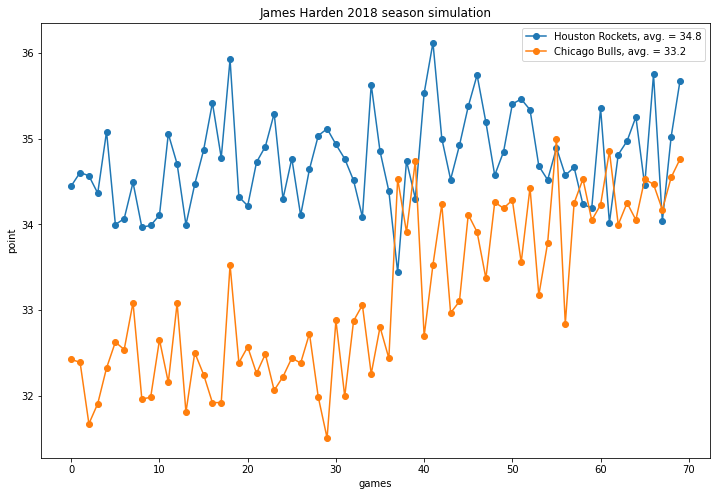

In [619]:
plt.figure(figsize=(12,8))
plt.plot(pred_player_1[:70], linestyle='-', marker='o', label='Houston Rockets, avg. = 34.8')
plt.plot(pred_player_2[:70], linestyle='-', marker='o', label='Chicago Bulls, avg. = 33.2')
plt.xlabel('games')
plt.ylabel('point')
plt.title('James Harden 2018 season simulation')
plt.legend()
plt.show()